<a href="https://colab.research.google.com/github/KristianMiok/Bayesian-BERT/blob/main/MCD%20BERT%20EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.0MB 4.4MB/s 
     |████████████████████████████████| 3.0MB 23.7MB/s 
     |████████████████████████████████| 1.1MB 41.1MB/s 
     |████████████████████████████████| 890kB 54.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=1603b0a23bd1159580b530c980c1af74cb024379e47c1d01f843831e81682681
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=3358b99f6dd6a85cbcbd47f6d6ed0b9c88fe0c5987b1e30493a6dba6d3af155d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
# Our data set!

In [ ]:
# Access to resources
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Read data from file
import pandas as pd
from sklearn.utils import shuffle

# Point to the file in Google Drive
filename='/content/gdrive/My Drive/big_dataset.csv'
#filename='/content/gdrive/My Drive/EN_HS/big_dataset.csv'
df = pd.read_csv(filename, sep=',')

In [ ]:
df.columns

Index(['id', 'label', 'tweet', 'normalized_text'], dtype='object')

In [ ]:
df = df.reset_index(drop=True)
df.head()

,id,label,tweet,normalized_text
0,5964,0,@user #nbaupdates #nbadraft #cleveland f...,nbaupdates nbadraft cleveland father day pleas...
1,15185,0,just saw tv commercial for @user milk. there's...,saw tv commercial milk nothing fair life dairy...
2,23078,0,@user #gogirl #summer #camps #cardiff #girls ...,gogirl summer camp cardiff girl confident book...
3,7989,0,collection launch on the 25th june @user #a ...,collection launch th june bedford aist bluesky
4,15333,0,exciting times ahead!! #greatplacetowork #next...,excite time ahead nextchapter roydsllp withking


In [ ]:
from sklearn.utils import shuffle
df1= shuffle(df, random_state=500)
df1.head()

,id,label,tweet,normalized_text
2187,5214,0,love love love being surprised... but i love s...,love love love surprised love surprising peopl...
116,3536,0,@user almost ready for the new addition to the...,almost ready new addition davis household dogf...
4973,31740,1,@user my video on the whole @user situation #b...,video whole situation boycottdelta expose trut...
834,7388,0,south sudan unrest exacerbated by conflict amo...,south sudan unrest exacerbate conflict among c...
1370,14917,0,fans didn't follow me back,fan not follow back


In [ ]:
df2 = df1.reset_index(drop=True)
df2.head()

,id,label,tweet,normalized_text
0,5214,0,love love love being surprised... but i love s...,love love love surprised love surprising peopl...
1,3536,0,@user almost ready for the new addition to the...,almost ready new addition davis household dogf...
2,31740,1,@user my video on the whole @user situation #b...,video whole situation boycottdelta expose trut...
3,7388,0,south sudan unrest exacerbated by conflict amo...,south sudan unrest exacerbate conflict among c...
4,14917,0,fans didn't follow me back,fan not follow back


In [ ]:
train = pd.DataFrame(df2.iloc[:4000,:])
test = pd.DataFrame(df2.iloc[4000:,:])

In [ ]:
# Get the lists of sentences and their labels.
sentences = train.tweet.values
labels = train.label.values

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  love love love being surprised... but i love surprising people even more  
Tokenized:  ['love', 'love', 'love', 'being', 'surprised', '.', '.', '.', 'but', 'i', 'love', 'surprising', 'people', 'even', 'more']
Token IDs:  [2293, 2293, 2293, 2108, 4527, 1012, 1012, 1012, 2021, 1045, 2293, 11341, 2111, 2130, 2062]


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[1])
print('Token IDs:', input_ids[1])

Original:  @user almost ready for the new addition to the davis household   #dogforlife 
Token IDs: [101, 1030, 5310, 2471, 3201, 2005, 1996, 2047, 2804, 2000, 1996, 4482, 4398, 1001, 3899, 29278, 15509, 102]


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  55


In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0

Done.


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 80% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

# We set all of the tweets into the batches
batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
train_inputs

tensor([[  101,  2047,  2733,  ...,     0,     0,     0],
        [  101,  3232,  2383,  ...,     0,     0,     0],
        [  101,  1001,  6209,  ...,     0,     0,     0],
        ...,
        [  101,  1030,  5310,  ...,     0,     0,     0],
        [  101,  6289, 23644,  ...,     0,     0,     0],
        [  101,  1996, 13521,  ...,     0,     0,     0]])

In [ ]:
# Loading BERT that we need!

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    #mnum_labels = 1, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
# Fine tuning!

import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []


# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    450.    Elapsed: 0:00:05.
  Batch    80  of    450.    Elapsed: 0:00:10.
  Batch   120  of    450.    Elapsed: 0:00:16.
  Batch   160  of    450.    Elapsed: 0:00:21.
  Batch   200  of    450.    Elapsed: 0:00:26.
  Batch   240  of    450.    Elapsed: 0:00:31.
  Batch   280  of    450.    Elapsed: 0:00:37.
  Batch   320  of    450.    Elapsed: 0:00:42.
  Batch   360  of    450.    Elapsed: 0:00:47.
  Batch   400  of    450.    Elapsed: 0:00:53.
  Batch   440  of    450.    Elapsed: 0:00:58.

  Average training loss: 0.40
  Training epcoh took: 0:00:59

Running Validation...
  Accuracy: 0.88
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    450.    Elapsed: 0:00:05.
  Batch    80  of    450.    Elapsed: 0:00:10.
  Batch   120  of    450.    Elapsed: 0:00:16.
  Batch   160  of    450.    Elapsed: 0:00:21.
  Batch   200  of    450.    Elapsed: 0:00:26.
  Batch   240  of    450.    Elap

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/My Drive/EN_HS/model")

In [ ]:
#model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load('/content/gdrive/My Drive/EN_HS/model'))
model.eval()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


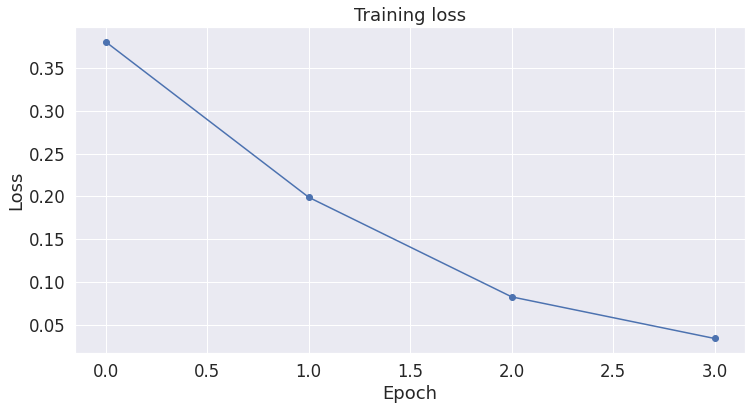

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
# Test Dataset!

import pandas as pd

# Load the dataset into a pandas dataframe.
#df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df= test
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = test.tweet.values
labels = test.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, 
                                   sampler=prediction_sampler,
                                   batch_size=batch_size)

Number of test sentences: 1,000



In [ ]:
import numpy as np

def softmax(x):

    e_x = np.exp(x - np.max(x))

    return e_x / e_x.sum()

from scipy.special import softmax    

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

y= pd.DataFrame()

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  pred=[]
  collect=[]
  p=[]
  #w=[]
  w = pd.DataFrame()

  model.train()
  pred = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  p=pred[0].detach().cpu().numpy()
  x = np.reshape(p, (8, 2))
  x = pd.DataFrame(x)
  x2 = softmax(x, axis=1)
  x3 = x2.drop([0], axis=1)
  y = y.append(x3)
  # w = pd.concat([w, x3], axis=1, ignore_index=True)


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,000 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 465 of 1000 (46.50%)


In [ ]:
# predictions = pd.DataFrame(predictions)
# predictions.head()

In [ ]:
x2 = softmax(predictions, axis=1)
#x3 = x2.drop([0], axis=1)

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
matthews_set

[1.0,
 0.2581988897471611,
 1.0,
 1.0,
 1.0,
 0.5773502691896258,
 0.4879500364742666,
 0.6546536707079772,
 1.0,
 0.7453559924999299,
 1.0,
 0.7453559924999299,
 1.0,
 0.4666666666666667,
 0.6,
 1.0,
 1.0,
 1.0,
 1.0,
 0.7745966692414834,
 0.5773502691896258,
 1.0,
 0.5773502691896258,
 1.0,
 1.0,
 0.7453559924999299,
 0.2581988897471611,
 1.0,
 0.7745966692414834,
 1.0,
 0.4879500364742666,
 1.0,
 1.0,
 1.0,
 0.6,
 0.6546536707079772,
 1.0,
 0.7453559924999299,
 0.7745966692414834,
 0.2581988897471611,
 0.7453559924999299,
 0.7745966692414834,
 1.0,
 1.0,
 0.7453559924999299,
 1.0,
 0.7453559924999299,
 0.6546536707079772,
 1.0,
 1.0,
 0.7745966692414834,
 0.7453559924999299,
 0.7745966692414834,
 0.5,
 0.6,
 1.0,
 1.0,
 0.7453559924999299,
 0.7745966692414834,
 1.0,
 0.7745966692414834,
 0.5,
 0.7453559924999299,
 1.0,
 0.3333333333333333,
 1.0,
 1.0,
 0.7745966692414834,
 0.6,
 1.0,
 0.7453559924999299,
 1.0,
 1.0,
 0.5773502691896258,
 0.7745966692414834,
 0.7745966692414834,
 0.7

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.807


In [ ]:
flat_predictions

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,

In [ ]:
flat_true_labels= pd.DataFrame(flat_true_labels)
flat_predictions= pd.DataFrame(flat_predictions) 

In [ ]:
test = pd.DataFrame(test)

test=test.reset_index(drop=True)

test.columns

Index(['id', 'label', 'tweet', 'normalized_text'], dtype='object')

In [ ]:
true= test['label']
true
y= y.reset_index(drop=True)

In [ ]:
text=test['tweet']
text= pd.DataFrame(text)
text=text.reset_index(drop=True)
text.shape

(1000, 1)

In [ ]:
y

,1
0,0.000672
1,0.000285
2,0.001988
3,0.000841
4,0.999228
...,...
995,0.999527
996,0.999129
997,0.000602
998,0.998974


In [ ]:
result = pd.concat([y, true], axis=1, sort=False)
#result = pd.concat([flat_true_labels, y], axis=1, ignore_index=True)

In [ ]:
result.shape

(1000, 2)

In [ ]:
result = pd.concat([flat_true_labels,flat_predictions], axis=1, sort=False)
#result = pd.concat([test, y], axis=1, ignore_index=True)

In [ ]:
result

,0,0
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
995,1,1
996,1,1
997,0,0
998,1,1


In [ ]:
# result.to_csv(r'/content/gdrive/My Drive/EN_HS/only_pred.csv')

In [ ]:
 #flat_accuracy(predictions, true_labels)

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 465 of 1000 (46.50%)


In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracies_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.
  #matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  accuracy = accuracy_score(true_labels[i], pred_labels_i)                
  accuracies_set.append(accuracy)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
accuracies_set

[1.0,
 0.625,
 1.0,
 1.0,
 1.0,
 0.75,
 0.75,
 0.875,
 1.0,
 0.875,
 1.0,
 0.875,
 1.0,
 0.75,
 0.75,
 1.0,
 1.0,
 1.0,
 1.0,
 0.875,
 0.75,
 1.0,
 0.75,
 1.0,
 1.0,
 0.875,
 0.625,
 1.0,
 0.875,
 1.0,
 0.75,
 1.0,
 1.0,
 1.0,
 0.75,
 0.875,
 1.0,
 0.875,
 0.875,
 0.625,
 0.875,
 0.875,
 1.0,
 1.0,
 0.875,
 1.0,
 0.875,
 0.875,
 1.0,
 1.0,
 0.875,
 0.875,
 0.875,
 0.75,
 0.75,
 1.0,
 1.0,
 0.875,
 0.875,
 1.0,
 0.875,
 0.75,
 0.875,
 1.0,
 0.75,
 1.0,
 1.0,
 0.875,
 0.75,
 1.0,
 0.875,
 1.0,
 1.0,
 0.75,
 0.875,
 0.875,
 0.875,
 1.0,
 0.75,
 1.0,
 1.0,
 1.0,
 1.0,
 0.875,
 0.875,
 1.0,
 0.875,
 0.875,
 0.875,
 0.75,
 1.0,
 1.0,
 0.75,
 0.875,
 0.875,
 0.875,
 0.875,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.875,
 1.0,
 1.0,
 1.0,
 1.0,
 0.625,
 0.75,
 0.5,
 1.0,
 1.0,
 1.0,
 0.75,
 0.875,
 0.875,
 1.0,
 0.875,
 1.0,
 0.75,
 1.0,
 0.875,
 1.0,
 0.875]

In [ ]:

# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the Acc
#mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
acc = accuracy_score(flat_true_labels, flat_predictions)
pre = precision_score(flat_true_labels, flat_predictions)
rec = recall_score(flat_true_labels, flat_predictions)
f1 = f1_score(flat_true_labels, flat_predictions)

print('ACC: %.3f' % acc)
print('PRE: %.3f' % pre)
print('REC: %.3f' % rec)
print('F1: %.3f' % f1)

ACC: 0.903
PRE: 0.874
REC: 0.925
F1: 0.899
